In [52]:
from fastai.imports import *
np.set_printoptions(linewidth=100)

import os

df = pd.read_csv('./train.csv')
tst_df = pd.read_csv('./test.csv')
modes = df.mode().iloc[0]

cats=["Sex","Embarked"]
conts=['Age', 'SibSp', 'Parch', 'LogFare',"Pclass"]
dep="Survived"

from sklearn.impute import KNNImputer
from sklearn.metrics import mean_absolute_error

def proc_data(df): # Define a function to process the data
    df['Fare'] = df.Fare.fillna(0) # Fill any missing values in the 'Fare' column with 0
    #df.fillna(modes, inplace=True) # Fill any missing values in other columns with pre-calculated modes (commonly occurring values)
        
    df['LogFare'] = np.log1p(df['Fare']) # Create a new column 'LogFare' which is the logarithm (plus 1) of the 'Fare' column to handle cases where Fare might be 0
    df['Embarked'] = pd.Categorical(df.Embarked) # Convert the 'Embarked' column to a categorical datatype, facilitating encoding for modeling
    df['Sex'] = pd.Categorical(df.Sex) # Convert the 'Sex' column to a categorical datatype
    
    imputer = KNNImputer(n_neighbors=2)
    df[conts] = imputer.fit_transform(df[conts])

proc_data(df) # Apply the function to the main data (commonly training data)
proc_data(tst_df) # Apply the function to the test data

print(round(df.describe(percentiles=[0.25, 0.50, 0.75, 0.99, 1.00]), 2))

       PassengerId  Survived  Pclass     Age   SibSp   Parch    Fare  LogFare
count       891.00    891.00  891.00  891.00  891.00  891.00  891.00   891.00
mean        446.00      0.38    2.31   29.88    0.52    0.38   32.20     2.96
std         257.35      0.49    0.84   13.98    1.10    0.81   49.69     0.97
min           1.00      0.00    1.00    0.42    0.00    0.00    0.00     0.00
25%         223.50      0.00    2.00   21.00    0.00    0.00    7.91     2.19
50%         446.00      0.00    3.00   28.00    0.00    0.00   14.45     2.74
75%         668.50      1.00    3.00   38.00    1.00    0.00   31.00     3.47
99%         882.10      1.00    3.00   65.10    5.00    4.00  249.01     5.52
100%        891.00      1.00    3.00   80.00    8.00    6.00  512.33     6.24
max         891.00      1.00    3.00   80.00    8.00    6.00  512.33     6.24


In [53]:
from numpy import random
from sklearn.model_selection import train_test_split

random.seed(6100)
trn_df,val_df = train_test_split(df, test_size=0.25)
trn_df[cats] = trn_df[cats].apply(lambda x: x.cat.codes)
val_df[cats] = val_df[cats].apply(lambda x: x.cat.codes)

In [54]:
def xs_y(df):
    xs = df[cats+conts].copy()
    return xs,df[dep] 

trn_xs,trn_y = xs_y(trn_df)
val_xs,val_y = xs_y(val_df)

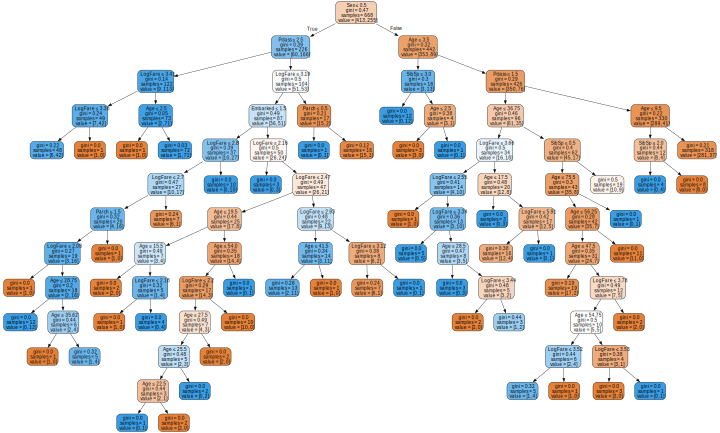

In [57]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

m = DecisionTreeClassifier(max_leaf_nodes=50).fit(trn_xs, trn_y);

import graphviz

def draw_tree(t, df, size=10, ratio=0.6, precision=2, **kwargs):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True, rounded=True,
                      special_characters=True, rotate=False, precision=precision, **kwargs)
    return graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', s))

draw_tree(m, trn_xs, size=10)


In [56]:
mean_absolute_error(val_y, m.predict(val_xs))

0.1210762331838565